# Lab 7: Sequential Networks

**Name(s):** Emmanuel Garcia, Nimai Keshu, Tiffany Nguyen, Luke Voinov

We use the Grammar Error Correction Dataset:

https://www.kaggle.com/datasets/programmer3/grammar-error-correction-dataset

This dataset contains grammatically incorrect sentences, how advanced the english learner is, what the topic is, they type of error they made, and more. There are 8 classes for the error type and our system will predict the type of error a user makes based on an incorrect sentence. If the user says "He bought two breads", the error type will be "Noun Form".

Much of the code in this dataset was adapted from Eric Larson, 13a. Sequence Basics [experimental].ipynb

https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb

We denote this reference with (1)

In [40]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

print('Pandas:', pd.__version__)
print('Numpy:',np.__version__)
# Python: 3.12.3

Pandas: 2.3.2
Numpy: 1.26.4


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !find "/content/drive" -maxdepth 7 -type d -iname "grammar"

# **1 Preparation**

1.1 *Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used (include a description of any newly formed variables you created). It is preferred to use tf.dataset and Keras Feature spaces for pre-processing, but it is not required.*

In [7]:
# read the items.csv (book information) into df1
path = "grammar_error_dataset.csv"
df = pd.read_csv(path, encoding='utf-8')

In [8]:
df.head()

,ID,Learner_Proficiency,Topic,Original_Sentence,Error_Type,Corrected_Sentence,Grammar_Rule,POS_Tagged,Tokenized,Error_Position
0,1,Advanced,Health,He bought two breads.,Noun Form,He bought two loaves of bread.,Use correct plural form or measure word.,He/PRP bought/VBD two/CD breads/NNS ./.,He bought two breads .,1
1,2,Advanced,Health,She go to market yesterday.,Verb Tense,She went to the market yesterday.,Use past tense for actions completed in the past.,She/PRP go/VBP to/TO market/NN yesterday/NN ./.,She go to market yesterday .,0
2,3,Advanced,Sports,Always I drink coffee in morning.,Word Order,I always drink coffee in the morning.,Adverbs of frequency go before the main verb.,Always/NNS I/PRP drink/VBP coffee/NN in/IN mor...,Always I drink coffee in morning .,1
3,4,Beginner,Sports,Always I drink coffee in morning.,Word Order,I always drink coffee in the morning.,Adverbs of frequency go before the main verb.,Always/NNS I/PRP drink/VBP coffee/NN in/IN mor...,Always I drink coffee in morning .,2
4,5,Beginner,Technology,He is married with a doctor.,Preposition,He is married to a doctor.,‘Married to’ is the correct collocation.,He/PRP is/VBZ married/VBN with/IN a/DT doctor/...,He is married with a doctor .,4


In [9]:
print(f"\nItems shape: {df.shape}")
print(f"Items dtypes:\n{df.dtypes}")


Items shape: (1750, 10)
Items dtypes:
ID                      int64
Learner_Proficiency    object
Topic                  object
Original_Sentence      object
Error_Type             object
Corrected_Sentence     object
Grammar_Rule           object
POS_Tagged             object
Tokenized              object
Error_Position          int64
dtype: object


#### Data Cleaning

First, we see if any data is missing. Next, we'll remove, combine, or create columns.

Text(0.5, 1.0, 'Missing Data Visual')

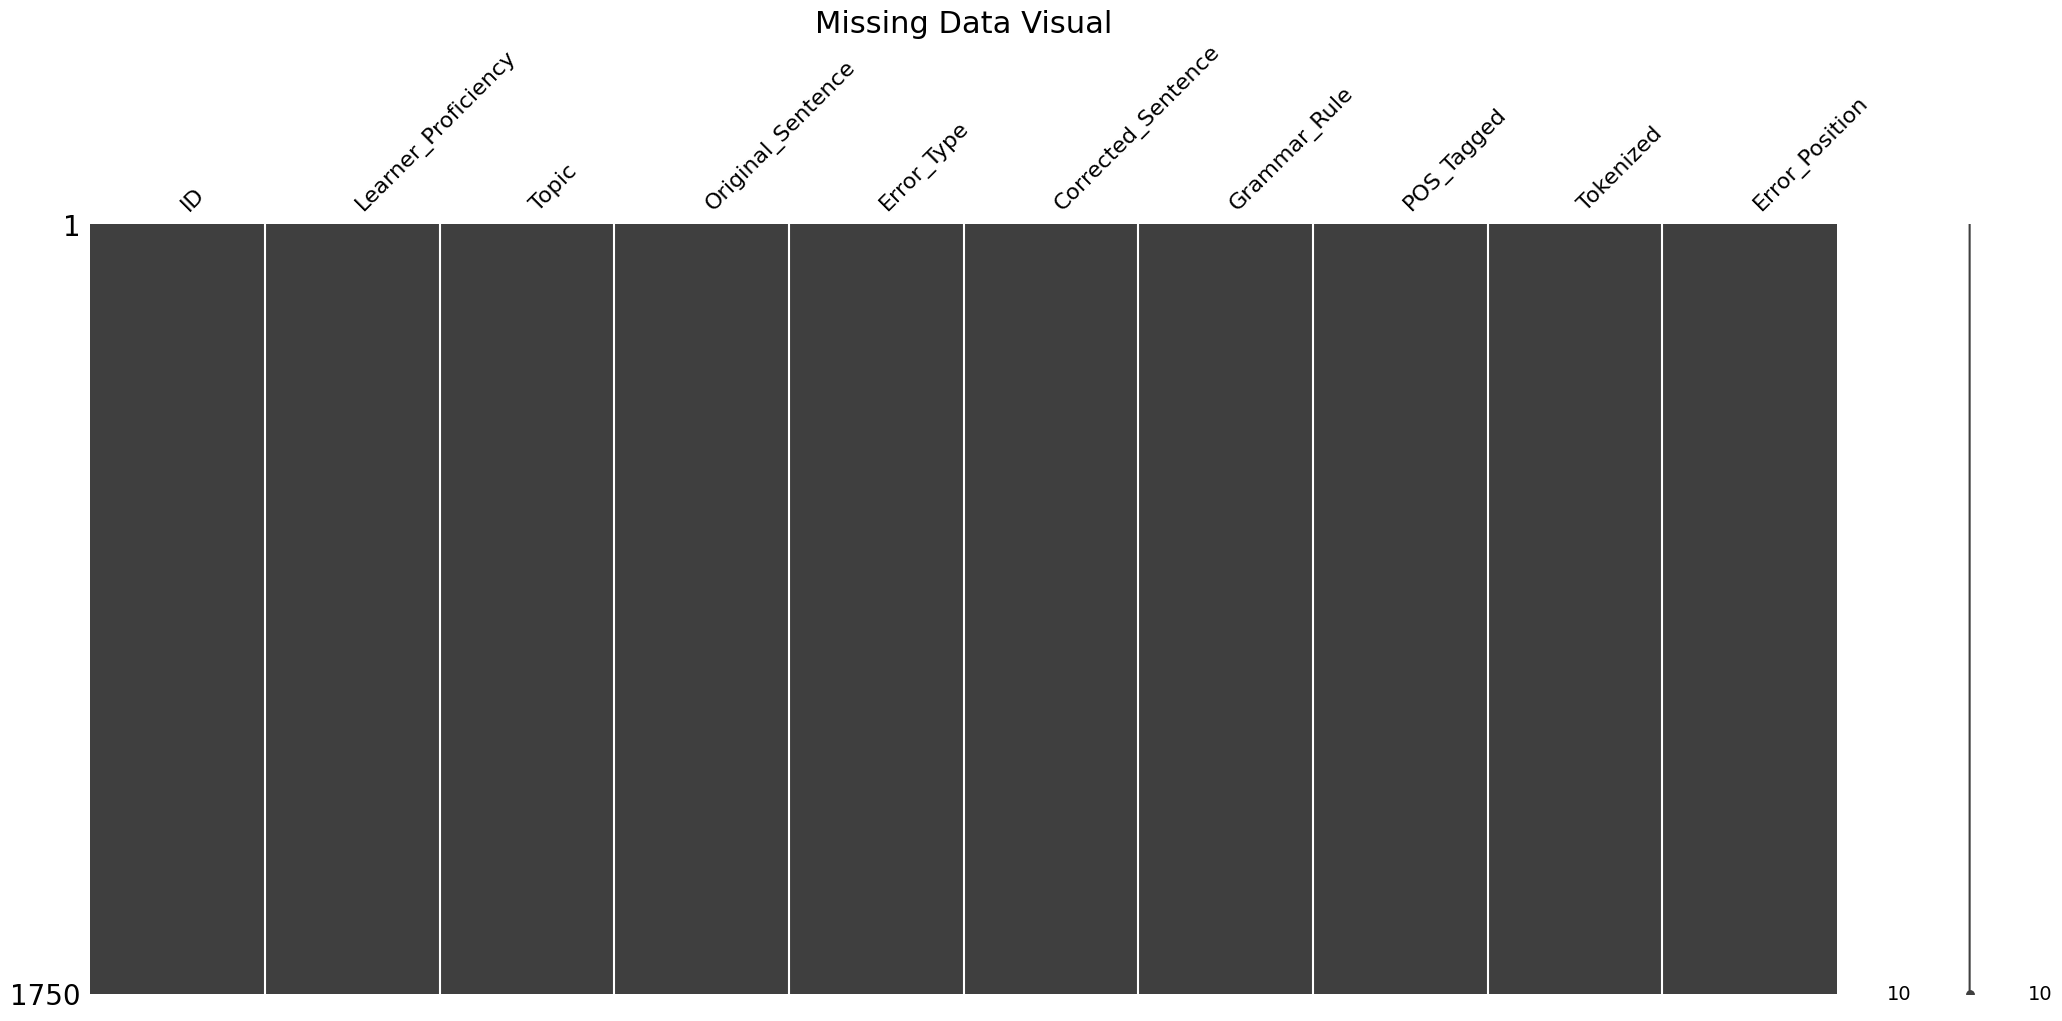

In [10]:
# Code adapted from voinv_lab1.ipynb

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# External package: conda install missingno 
import missingno as mn

mn.matrix(df)
plt.title("Missing Data Visual",fontsize=22)

We remove the ID, Corrected_Sentence, POS_Tagged, Tokenized, and Error_Position columns. 

The ID column won't contribue any meaningful information about the grammar. It's an artifact of organizing the data and has no realtion to a person's grammar other than associating a person with a number.

The Corrected_Sentence column could be useful in helping the algorithm figure out how to correct a grammar error, but since it would be OHE, it wouldn't contribute much meaningful information either. For example, all instances of "He bought two bread." will be associated with the corrected "He bought two loaves of bread." When it comes to learning grammatical realtions, this would be useful, but because it would be OHE, the algorithm will lose any information "inside" the sentence and learn to associate this exact grammatical mistake with this exact correction. It is doubtful this would be enough for the algorithm to generalize onto new sentences and fix their errors given that Corrected_Senteces is OHE, so there is no reason to include this column. POS_Tagged is in the same situation.

Tokenized is just a repeat of the Original_Sentence column, so we remove it.

Error_Position would be useful if it was consistent. In just the first few instances of "He bought two bread.", the error position is either 1, 2, or 3! Given this inconsistency, it's likely this column will just include more noise in the results, so we remove it.

In [11]:
# Code to drop the columns discussed above

df = df.drop(columns=["ID", "Corrected_Sentence", "POS_Tagged", "Tokenized", "Error_Position"])
df.head()

,Learner_Proficiency,Topic,Original_Sentence,Error_Type,Grammar_Rule
0,Advanced,Health,He bought two breads.,Noun Form,Use correct plural form or measure word.
1,Advanced,Health,She go to market yesterday.,Verb Tense,Use past tense for actions completed in the past.
2,Advanced,Sports,Always I drink coffee in morning.,Word Order,Adverbs of frequency go before the main verb.
3,Beginner,Sports,Always I drink coffee in morning.,Word Order,Adverbs of frequency go before the main verb.
4,Beginner,Technology,He is married with a doctor.,Preposition,‘Married to’ is the correct collocation.


In [12]:
print(f"\nItems shape: {df.shape}")
print(f"Items dtypes:\n{df.dtypes}")


Items shape: (1750, 5)
Items dtypes:
Learner_Proficiency    object
Topic                  object
Original_Sentence      object
Error_Type             object
Grammar_Rule           object
dtype: object


#### Miscellaneous Checks

In [13]:
# Check the unique classes in the target variable
print("Unique classes in the target variable:", df["Error_Type"].unique())
# Check the unique classes in the target variable
print("# of unique classes in the target variable:", len(df["Error_Type"].unique()))

Unique classes in the target variable: ['Noun Form' 'Verb Tense' 'Word Order' 'Preposition' 'Pronoun' 'Article'
 'Subject-Verb Agreement']
# of unique classes in the target variable: 7


Check for class imbalance?

In [14]:
# extract number of instances in each class
labels = df["Error_Type"].unique()
class_amts = []
for c in labels:
    mask = df["Error_Type"] == c
    class_amts.append( len(df[mask]) )
print(class_amts)

[273, 236, 229, 238, 249, 248, 277]


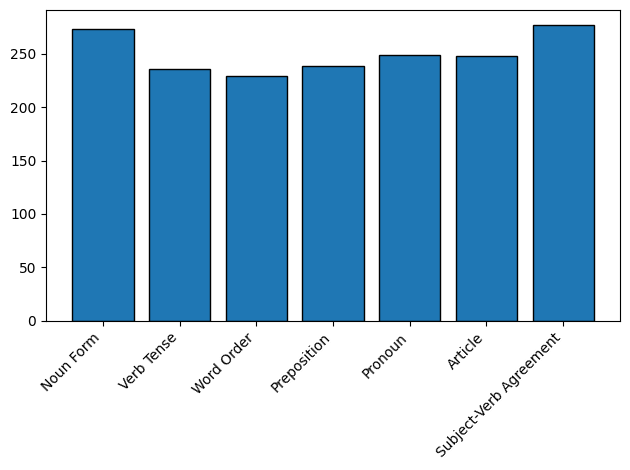

In [15]:
plt.figure()
plt.bar(labels, class_amts, edgecolor="k")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There is no class imbalance so we don't have to worry about splitting techinques to keep this in account.

#### Encoding

Now, we will encode Learner_Proficiency as a catgorical variable and Topic, Error_Type, and Grammar_Rule with OHE. Notice that there is no need to normalize the data because there's no numerical data.

In [16]:
# Encode Learner_Proficiency as categorical. 
# Github Copilot helped makes sure the order is beginner, intermediate, advanced
proficiency_mapping = {
    'Beginner': 0,
    'Intermediate': 1,
    'Advanced': 2
}
df["Learner_Proficiency"] = df["Learner_Proficiency"].map(proficiency_mapping)

print("Learner_Proficiency mapping:", proficiency_mapping)

Learner_Proficiency mapping: {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}


In [17]:
df.head(3)

,Learner_Proficiency,Topic,Original_Sentence,Error_Type,Grammar_Rule
0,2,Health,He bought two breads.,Noun Form,Use correct plural form or measure word.
1,2,Health,She go to market yesterday.,Verb Tense,Use past tense for actions completed in the past.
2,2,Sports,Always I drink coffee in morning.,Word Order,Adverbs of frequency go before the main verb.


In [18]:
# One-hot encode Error_Type, Grammar_Rule, and Topic
df_ohe = pd.get_dummies(df, columns=['Error_Type', 'Grammar_Rule', 'Topic'])
df_ohe

,Learner_Proficiency,Original_Sentence,Error_Type_Article,Error_Type_Noun Form,Error_Type_Preposition,Error_Type_Pronoun,Error_Type_Subject-Verb Agreement,Error_Type_Verb Tense,Error_Type_Word Order,Grammar_Rule_Adverbs of frequency go before the main verb.,...,Grammar_Rule_Use subject pronouns in the subject position.,Grammar_Rule_‘Homework’ is uncountable; no article needed.,Grammar_Rule_‘Married to’ is the correct collocation.,Topic_Daily Life,Topic_Education,Topic_Health,Topic_Sports,Topic_Technology,Topic_Travel,Topic_Work
0,2,He bought two breads.,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,2,She go to market yesterday.,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,2,Always I drink coffee in morning.,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
3,0,Always I drink coffee in morning.,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
4,0,He is married with a doctor.,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,2,I have an homework to finish.,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
1746,2,Always I drink coffee in morning.,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,True,False,False
1747,0,I have an homework to finish.,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1748,0,She go to market yesterday.,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [19]:
print(f"\nItems shape: {df_ohe.shape}")
print(f"Items dtypes:\n{df_ohe.dtypes}")


Items shape: (1750, 23)
Items dtypes:
Learner_Proficiency                                                int64
Original_Sentence                                                 object
Error_Type_Article                                                  bool
Error_Type_Noun Form                                                bool
Error_Type_Preposition                                              bool
Error_Type_Pronoun                                                  bool
Error_Type_Subject-Verb Agreement                                   bool
Error_Type_Verb Tense                                               bool
Error_Type_Word Order                                               bool
Grammar_Rule_Adverbs of frequency go before the main verb.          bool
Grammar_Rule_Plural subjects require plural verbs.                  bool
Grammar_Rule_Use correct plural form or measure word.               bool
Grammar_Rule_Use past tense for actions completed in the past.      bool
Grammar_Rule

#### Tokenization

Because our sentences are very short, we decide to use each word as one token. Each punctiation mark will be considered its own token (e.g. 'bread' and '.' will be seperate tokens). This is to make the syste eb able to generalize a little better, otherwise it would always think bread comes with a period (since every example here that uses bread ends with a period)

Since our senteces are short, every word matters. An advantage of this short lenght is that we don't have to cut anything off, so we'll zero pad shorter sentences up to the max ssetence lenght. We determine what this number is below:

In [20]:
# extract each sentence
labels = df_ohe["Original_Sentence"].unique()
sentence_len = []
for c in labels:
    word = 2 # start with 1 to account for the last word not having a space and the period as a seperate token
    for ch in c:
        if ch == ' ':
            word += 1
    sentence_len.append(word)

print("Max words in a sentence: ", max(sentence_len)
   ,"\nMin words in a sentence: ", min(sentence_len))

Max words in a sentence:  7 
Min words in a sentence:  5


This means that our maximum length sequence will be 7 and we will 0 pad our 5 token sentences by 2.

In [21]:
# Code adapted from (1). Code adapted from Github Copilot to tokenize punctuation as well
# This code tokenizes each word and punctuation mark. It then 0 pads each sequence.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

# Add space before periods so they become separate tokens
df_ohe["Original_Sentence"] = df_ohe["Original_Sentence"].str.replace('.', ' .', regex=False)

# Now tokenize with period kept
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df_ohe["Original_Sentence"])

sequences = tokenizer.texts_to_sequences(df_ohe["Original_Sentence"])

max_grammar_length = 7
df_ohe["Original_Sentence"] = list(sequence.pad_sequences(sequences, maxlen=max_grammar_length))

#### Final Dataset

In [22]:
df_ohe

,Learner_Proficiency,Original_Sentence,Error_Type_Article,Error_Type_Noun Form,Error_Type_Preposition,Error_Type_Pronoun,Error_Type_Subject-Verb Agreement,Error_Type_Verb Tense,Error_Type_Word Order,Grammar_Rule_Adverbs of frequency go before the main verb.,...,Grammar_Rule_Use subject pronouns in the subject position.,Grammar_Rule_‘Homework’ is uncountable; no article needed.,Grammar_Rule_‘Married to’ is the correct collocation.,Topic_Daily Life,Topic_Education,Topic_Health,Topic_Sports,Topic_Technology,Topic_Travel,Topic_Work
0,2,"[0, 0, 2, 9, 10, 11, 1]",False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,2,"[0, 26, 27, 3, 28, 29, 1]",False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,2,"[30, 4, 31, 32, 33, 34, 1]",False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
3,0,"[30, 4, 31, 32, 33, 34, 1]",False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
4,0,"[2, 21, 22, 23, 24, 25, 1]",False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,2,"[4, 17, 18, 19, 3, 20, 1]",True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
1746,2,"[30, 4, 31, 32, 33, 34, 1]",False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,True,False,False
1747,0,"[4, 17, 18, 19, 3, 20, 1]",True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1748,0,"[0, 26, 27, 3, 28, 29, 1]",False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


Our final dataset contains the same number of instances as the original - 1750 - but half the features. With one-hot encoding, however, there are 23 features. 

Significant features:

- Original_Sentence is tokenized and 0 padded, if needed. None of the tokens are cut off due to the sentences already beign short. Each word and punctuation mark (.) is treated as a token.
- Original_Sentence has 7 different grammatically incorrect sentences, meaning the 1750 instances are one of these 7 grammatically incorrect sentences. This is a decent starting point for training an error type classification system.
- Error_Type is the target class. There are 8 unique errors with between 230-270 instances for each error. Error_Type is one-hot encoded.
- Grammar_Rule and Topic are also one-hot encoded.
- Learner_Proficiency is categorically encoded because there is a relation between beginner, intermediate, and advanced levels.

The dataset contains no missing data. 

### Evaluation Metrics

1.2 *Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data and your business/policy case. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.*

Our algorithm will predict the type of grammatical error a user makes given their incorrect sentence. If the user says "He bought two breads", the system will output that the user's grammatical error is "Noun Form". 

This algorithm could be used for companies like Grammarly, Microsoft Word, Google Docs, or any other grammar / text editor service. In particular, it could be used to help user learn English. The user doesn't have to see that they're getting "Noun Form" incorrect, but if this algorithm is part of a larger grammar-checking system, this output would inform the system of which areas of grammar they're getting wrong the most and target improving that area. Thus, knowing that "Noun Form" is the most common mistake for this user, the system can narrow in on what practice problems it can give to help the user learn proper "Noun Form".

There isn't any positive or negative class in the case. None of the error types are more important than the other so it wouldn't make sense to use recall of precision. For example, is the scenario "He bought two bread." being misclassified as "Article" a false positive or a false negative? It's a false positive for the article class. A false negative would be "He bought two bread." being said to not be "Noun Form". However, this is equivalent to it being a false positive for "Article".

Thus, accuracy is a good metric for this situation because it will tell us how many of our classes are correctly attributed. As we saw earlier, there is no class imbalance between the error types so accuracy won't be misleading.

### Train-Test Split

1.3 *Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation?   Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.*

The **Stratified 10-fold cross-validation** is the most appropriate method for splitting the data into training and testing. This approach ensures that the class distribution is preserved, maintaining the proportions of each class in every fold. This is particularly important for fair evaluation, as it prevents underrepresented classes from being excluded or poorly represented in some folds. Our dataset is small enough to benefit from this method, yet not so small that it would leave insufficient data for training or testing.

Without stratification, there is a risk that certain classes might be excluded from some folds, leading to biased or unreliable evaluation results. Stratified 10-fold cross-validation addresses this by providing a robust and fair assessment of the model's performance. The data is split into 10 folds, and the model is trained and tested 10 times, with each fold serving as the validation set once while the remaining 9 folds are used for training. This ensures that every data point is utilized for both training and validation, maximizing the utility of the dataset.

This method is particularly well-suited for our dataset, as it allows us to make the most of the available data while still providing a reliable estimate of the model's ability to generalize to unseen data. Although the dataset is relatively small, it is large enough to support this approach without compromising the quality of the evaluation.


First, we need to change the string labels to integers before we instantiate the Stratified K Fold function for our dataset.

In [43]:
# Adapted from Copilot in order to change stringe labels to integers for dataset splitting

error_type_columns = [col for col in df_ohe.columns if col.startswith('Error_Type_')]

y = df_ohe[error_type_columns].idxmax(axis=1) # get the original error type labels

le = LabelEncoder() # to convert string labels to integers
y_encoded = le.fit_transform(y)

# printing out details
print("Target variable distribution:")
print(pd.Series(y).value_counts().sort_index())
print(f"\nTotal samples: {len(y)}") # 
print(f"Number of unique classes: {len(y.unique())}")

Target variable distribution:
Error_Type_Article                   248
Error_Type_Noun Form                 273
Error_Type_Preposition               238
Error_Type_Pronoun                   249
Error_Type_Subject-Verb Agreement    277
Error_Type_Verb Tense                236
Error_Type_Word Order                229
Name: count, dtype: int64

Total samples: 1750
Number of unique classes: 7


Now that everything should be prepared for split, we can move onto the part where can **finally** use StratifiedKFold to split the dataset!

In [45]:
# Adapted from Claude AI to implement StratifiedKFold, which maintains class distribution across folds
# Guidance from GeeksforGeeks: https://www.geeksforgeeks.org/stratifiedkfold-in-python/

# instantiating the StratifiedKFold
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# store fold information
fold_info = {
    'fold': [],
    'train_indices': [],
    'test_indices': [],
    'train_size': [],
    'test_size': []
}

# generating folds and printing out distributions in each fold and overall
for fold, (train_idx, test_idx) in enumerate(skf.split(df_ohe, y_encoded), 1):
    fold_info['fold'].append(fold)
    fold_info['train_indices'].append(train_idx)
    fold_info['test_indices'].append(test_idx)
    fold_info['train_size'].append(len(train_idx))
    fold_info['test_size'].append(len(test_idx))
    
    print(f"Fold {fold}:")
    print(f"  Training set size: {len(train_idx)} ({len(train_idx)/len(df_ohe)*100:.1f}%)")
    print(f"  Test set size: {len(test_idx)} ({len(test_idx)/len(df_ohe)*100:.1f}%)")
    
    # check class distribution in train and test sets
    train_dist = pd.Series(y.iloc[train_idx]).value_counts().sort_index()
    test_dist = pd.Series(y.iloc[test_idx]).value_counts().sort_index()
    
    print(f"  Training set distribution:")
    for error_type, count in train_dist.items():
        print(f"    {error_type}: {count} ({count/len(train_idx)*100:.1f}%)")
    
    print(f"  Test set distribution:")
    for error_type, count in test_dist.items():
        print(f"    {error_type}: {count} ({count/len(test_idx)*100:.1f}%)")
    print()

# summary is stored into a DataFrame (may remove later, not sure if it's useful for us yet)
fold_summary = pd.DataFrame({
    'Fold': fold_info['fold'],
    'Train Size': fold_info['train_size'],
    'Test Size': fold_info['test_size']
})

Fold 1:
  Training set size: 1575 (90.0%)
  Test set size: 175 (10.0%)
  Training set distribution:
    Error_Type_Article: 223 (14.2%)
    Error_Type_Noun Form: 245 (15.6%)
    Error_Type_Preposition: 214 (13.6%)
    Error_Type_Pronoun: 224 (14.2%)
    Error_Type_Subject-Verb Agreement: 250 (15.9%)
    Error_Type_Verb Tense: 213 (13.5%)
    Error_Type_Word Order: 206 (13.1%)
  Test set distribution:
    Error_Type_Article: 25 (14.3%)
    Error_Type_Noun Form: 28 (16.0%)
    Error_Type_Preposition: 24 (13.7%)
    Error_Type_Pronoun: 25 (14.3%)
    Error_Type_Subject-Verb Agreement: 27 (15.4%)
    Error_Type_Verb Tense: 23 (13.1%)
    Error_Type_Word Order: 23 (13.1%)

Fold 2:
  Training set size: 1575 (90.0%)
  Test set size: 175 (10.0%)
  Training set distribution:
    Error_Type_Article: 223 (14.2%)
    Error_Type_Noun Form: 245 (15.6%)
    Error_Type_Preposition: 214 (13.6%)
    Error_Type_Pronoun: 224 (14.2%)
    Error_Type_Subject-Verb Agreement: 250 (15.9%)
    Error_Type_Verb Te

### Note for later: Make a confusion matrix to see which one it gets most wrong